In [75]:
# 목표 : XGBOOST를 위한 파라미터튜닝을 이해하고 feature enginnering 하고 xgboost model train fit predict validation 하기
import pandas as pd
import numpy as np
import os
from joblib import Parallel, delayed
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import lightgbm as lgb
import xgboost as xgb
import joblib
from sklearn.metrics import f1_score

from sklearn.base import clone
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [4]:
from sklearn.utils import class_weight

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# this only transforms the idhogar field,
# the other things this functinon used to go are done elsewhere
def encode_data(df):
    df['idhogar'] = LabelEncoder().fit_transform(df['idhogar'])

In [8]:
def process_df(df_):
    # encode the idhogar
    encode_data(df_)

    # create aggregate features
    return do_features(df_)

In [9]:
def do_features(df):
    feats_div = [('children_fraction','r4t1', 'r4t3'),
                 ('working_man_fraction' ,'r4h2' ,'r4t3') ,
                 ('all_man_fraction', 'r4h3', 'r4t3') ,
                 ('human_density', 'tamviv' , 'rooms'),
                 ('human_bed_density', 'tamviv' , 'bedrooms'),
                 ('rent_per_person' , 'v2a1', 'r4t3'),
                 ('rent_per_room' , 'v2a1' , 'rooms') ,
                 ('mobile_density' , 'qmobilephone' , 'r4t3'),
                 ('tablet_density' , 'v18q1' , 'r4t3'),
                 ('mobile_adult_density' , 'qmobilephone', 'r4t2'),
                 ('tablet_adult_density' , 'v18q1', 'r4t2'),
                 ]
    feats_sub = [('people_not_living' , 'tamhog' , 'tamviv'),
                 ('people_weird_stat' , 'tamhog' , 'r4t3')]

    # 이미 가지고 있는 컬럼을 가지고 무언가 조작을 한다 대부분
    for f_new, f1, f2 in feats_div:
        df['fe_' + f_new] = (df[f1] / df[f2]).astype(np.float32)
    for f_new, f1,f2 in feats_sub:
        df['fe_' + f_new] = (df[f1] - df[f2]).astype(np.float32)

    # aggregation rules over household
    aggs_num = {'age' : ['min' ,'max' ,'mean'],
                   'escolari'  : ['min','max', 'mean']
                 }

    aggs_cat = {'dis' : ['mean']}
    for s_ in ['estadocivil' , 'parentesco' , 'instlevel']:
        for f_ in [f_ for f_ in df.columns if f_.startswith(s_)]:
            aggs_cat[f_] = ['mean', 'count']

    # aggregation over household
    # col example : agg18_(age, estadocivil, esolari)

    #for name_, df_ in [('18', train.query('age >= 18'))]:
    # 대상 컬럼별 집계함수 aggs_num
    # * positional argument 는 말 그대로 함수 정의의 순서에 맞아야 한다 keyword는 아니고
    # positional argument로 넘기면 전체 데이터에 대해 idhogar groupby 했기 때문에 seriesgroupby 객체 별로 접근 하기 때문에 error가 난다
    #train.groupby('idhogar').agg({**aggs_num,**aggs_cat})
    #%%
    for name_, df_ in [('18', df.query('age >= 18'))]:
        df_agg = df_.groupby('idhogar').agg({**aggs_num , **aggs_cat}).astype(np.float32)
        df_agg.columns = pd.Index(['agg' + name_ + '_' + e[0] + "_"+ e[1].upper() for e in df_agg.columns.tolist()])
        df = df.join(df_agg , how='left' , on='idhogar')
        del df_agg

    #Drop id's
    df.drop(['Id'], axis=1 , inplace=True)

    return df

In [10]:
# plot feature importance for sklearn decision tree
def feature_importance(forest, X_train , display_results=True):

    ranked_list = []
    zero_features = []
    importances = forest.feature_importances_

    indices = np.argsort(importances)[::-1]

    if display_results:
        # Print the feature ranking
        print("Feature ranking:")

    for f in range(X_train.shape[1]):
        if display_results:
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]) + " - " +X_train.columns[indices[f]])
        ranked_list.append(X_train.columns[indices[f]])

        # zero import tance feature save
        if importances[indices[f]] == 0.0:
            zero_features.append(X_train.columns[indices[f]])

    return ranked_list, zero_features

In [ ]:
# ide 화면 크기 command 누르고 wheel 키 조정


In [ ]:
# feats_div = [('children_fraction','r4t1', 'r4t3'),
#                  ('working_man_fraction' ,'r4h2' ,'r4t3') ,
#                  ('all_man_fraction', 'r4h3', 'r4t3') ,
#                  ('human_density', 'tamviv' , 'rooms'),
#                  ('rent_per_person' , 'v2a1', 'r4t3'),
#                  ('rent_per_room' , 'v2a1' , 'rooms') ,
#                  ('mobile_density' , 'v18q1' , 'r4t3'),
#                  ('mobile_adult_density' , 'qmobilephone', 'r4t2'),
#                  ('tablet_adult_density' , 'v18q1', 'r4t2'),
#                  ]
# feats_sub = [('people_not_living' , 'tamhog' , 'tamviv'),
#              ('people_weird_stat' , 'tamhog' , 'r4t3')]


In [ ]:
# 이미 가지고 있는 컬럼을 가지고 무언가 조작을 한다 대부분
# for f_new, f1, f2 in feats_div:
#     train['fe_' + f_new] = (train[f1] / train[f2]).astype(np.float32)
# for f_new, f1,f2 in feats_sub:
#     train['fe_' + f_new] = (train[f1] - train[f2]).astype(np.float32)

In [11]:
# convert one hot encoded fields to label encoding

def convert_OHE2LE(df):
    tmp_df = df.copy(deep=True)

    for s_ in ['pared', 'piso', 'techo', 'abastagua', 'sanitario', 'energcocinar', 'elimbasu',
               'epared', 'etecho', 'eviv', 'estadocivil', 'parentesco',
               'instlevel', 'lugar', 'tipovivi',
               'manual_elec']:
        if 'manual_' not in s_:
            cols_s_ = [f_ for f_ in df.columns if f_.startswith(s_)]
        elif 'elec' in s_:
            cols_s_ = ['public' , 'planpri' , 'noelec' , 'coopele']
        sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()

        # deal with those OHE, where there is a sum over columns == 0
        if 0 in sum_ohe:
            print('The OHE in {} is incomplete. A new column will be added before label encoding'.format(s_))
            #dummy column name to be added
            col_dummy = s_+'_dummy'
            # add the column to the dataframe
            tmp_df[col_dummy] = (tmp_df[cols_s_].sum(axis=1) == 0 ).astype(np.int8)
            # add the name to the list of columns to be lebel-encoded
            cols_s_.append(col_dummy)
            # proof-check , that now the category is complete
            sum_ohe = tmp_df[cols_s_].sum(axis=1).unique()
            if 0 in sum_ohe:
                print("The category completion did not work")
        tmp_cat = tmp_df[cols_s_].idxmax(axis=1)
        tmp_df[s_ + '_LE'] = LabelEncoder().fit_transform(tmp_cat).astype(np.int16)
        if 'parentesco1' in cols_s_:
            cols_s_.remove('parentesco1')
        tmp_df.drop(cols_s_, axis=1, inplace=True)

    return tmp_df

In [12]:
# encapsule , function programming
def process_df(df_):
    # encode the idhogar
    encode_data(df_)

    return do_features(df_)

In [13]:
data_dir = './costa-rican-household-poverty-prediction/'

In [14]:
filename = 'train.csv'
train_path = os.path.join(data_dir, filename)

In [15]:
filename = 'test.csv'
test_path = os.path.join(data_dir, filename)

In [16]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [17]:
test_ids = test.Id

train = process_df(train)
test = process_df(test)

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,agg18_instlevel5_MEAN,agg18_instlevel5_COUNT,agg18_instlevel6_MEAN,agg18_instlevel6_COUNT,agg18_instlevel7_MEAN,agg18_instlevel7_COUNT,agg18_instlevel8_MEAN,agg18_instlevel8_COUNT,agg18_instlevel9_MEAN,agg18_instlevel9_COUNT
0,190000.0,0,3,0,1,1,0,NaN,0,1,...,0.00,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,135000.0,0,4,0,1,1,1,1.0,0,1,...,0.00,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
2,NaN,0,8,0,1,1,0,NaN,0,0,...,1.00,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,180000.0,0,5,0,1,1,1,1.0,0,2,...,1.00,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0
4,180000.0,0,5,0,1,1,1,1.0,0,2,...,1.00,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552,80000.0,0,6,0,1,1,0,NaN,0,2,...,0.25,4.0,0.0,4.0,0.0,4.0,0.0,4.0,0.0,4.0
9553,80000.0,0,6,0,1,1,0,NaN,0,2,...,0.25,4.0,0.0,4.0,0.0,4.0,0.0,4.0,0.0,4.0
9554,80000.0,0,6,0,1,1,0,NaN,0,2,...,0.25,4.0,0.0,4.0,0.0,4.0,0.0,4.0,0.0,4.0
9555,80000.0,0,6,0,1,1,0,NaN,0,2,...,0.25,4.0,0.0,4.0,0.0,4.0,0.0,4.0,0.0,4.0


In [18]:
train['dependency'] = np.sqrt(train['SQBdependency'])
test['dependency'] = np.sqrt(test['SQBdependency'])

In [19]:
train.loc[train['edjefa'] == "no", "edjefa"] =0
train.loc[train['edjefe'] == "no", "edjefe"] = 0

In [20]:
test.loc[test['edjefa'] == "no", "edjefa"] = 0
test.loc[test['edjefe'] == "no", "edjefe"] = 0

In [21]:
# if you ed
train.loc[(train['edjefe'] == "yes") & (train['parentesco1'] == 1), "edjefe"] = train.loc[(train['edjefe'] == 'yes') & (train['parentesco1']==1) , "escolari"]

In [22]:
train.loc[(train['edjefa'] == "yes") & (train['parentesco1'] ==1), "edjefa"] = train.loc[(train['edjefa'] =='yes') & (train['parentesco1'] ==1), "escolari"]

In [23]:
# 잡추천알고리즘 대분류 중분류 소분류 일치 여부도도 이런 식으로 만들면 될 것을

test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "edjefa"] = test.loc[(test['edjefa'] == "yes") & (test['parentesco1'] == 1), "escolari"]
test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "edjefe"] = test.loc[(test['edjefe'] == "yes") & (test['parentesco1'] == 1), "escolari"]

In [24]:
# the file is supposed to be interaction between gender and escolari , but it isn't clear what 'yes' mans, let's fill it with 4

In [25]:
train.loc[train['edjefa']=='yes', 'edjefa'] = 4
train.loc[train['edjefe'] =='yes', 'edjefe'] =4

#if education is "yes" and person is head of household , filee with escolari

In [26]:
test.loc[test['edjefa'] == "yes", "edjefa"] = 4
test.loc[test['edjefe'] == "yes", "edjefe"] = 4

In [27]:
# convert to int for our models
train['edjefe'] = train['edjefe'].astype("int")
train['edjefa'] = train['edjefa'].astype("int")

In [28]:
test['edjefe'] =  test['edjefe'].astype("int")
test['edjefa'] = test['edjefa'].astype("int")

In [29]:
# create feature with max education of either head of household
train['edjef'] = np.max(train[['edjefa','edjefe']],axis=1)
test['edjef'] = np.max(test[['edjefa','edjefe']],axis=1 )

In [30]:
# fill some nas
train['v2a1'] = train['v2a1'].fillna(0)

In [31]:
test['v2a1'] = test['v2a1'].fillna(0)

In [32]:
test['v18q1'] = test['v18q1'].fillna(0)
train['v18q1'] = train['v18q1'].fillna(0)

In [33]:
train['rez_esc'] = train['rez_esc'].fillna(0)
test['rez_esc'] = test['rez_esc'].fillna(0)

In [34]:
train.loc[train.meaneduc.isnull(), 'meaneduc'] =0
train.loc[train.SQBmeaned.isnull(), 'SQBmeaned'] = 0

In [35]:
test.loc[test.meaneduc.isnull(), 'meaneduc'] = 0
test.loc[test.SQBmeaned.isnull(), 'SQBmeaned'] = 0

In [36]:
# fix some inconsistencies in the data - some rows indicate both that the household does and does not have a toliet
# if there is no water we  ' ll assume they do not
# 물 공급이 없다면 없는걸로 가정한다

In [37]:
train.loc[(train.v14a == 1) & (train.sanitario1 == 1) & (train.abastaguano ==0 ) , "v14a"] = 0
train.loc[(train.v14a == 1 ) & (train.sanitario1 == 1) & (train.abastaguano == 0) , "sanitario1"] = 0

In [38]:
test.loc[(test.v14a ==1) & (test.sanitario1  == 1) & (test.abastaguano ==0) , "v14a"] = 0
test.loc[(test.v14a ==1) & (test.sanitario1 == 1) & (test.abastaguano == 0 ), "sanitario1"] = 0

In [39]:
def train_test_apply_func(train_, test_, func_):
    test_['Target'] = 0
    xx = pd.concat([train_,test_])

    xx_func = func_(xx)
    train_ = xx_func.iloc[:train_.shape[0],:]
    test_ = xx_func.iloc[train_.shape[0]:,:].drop('Target', axis=1)

    del xx, xx_func
    return train_, test_

In [40]:
# convert the one hot fields into label encoded
train , test = train_test_apply_func(train, test , convert_OHE2LE)

The OHE in techo is incomplete. A new column will be added before label encoding
The OHE in instlevel is incomplete. A new column will be added before label encoding
The OHE in manual_elec is incomplete. A new column will be added before label encoding


In [41]:
cols_2_ohe = ['eviv_LE', 'etecho_LE', 'epared_LE', 'elimbasu_LE',
              'energcocinar_LE', 'sanitario_LE', 'manual_elec_LE',
              'pared_LE']
cols_nums = ['age', 'meaneduc', 'dependency',
             'hogar_nin', 'hogar_adul', 'hogar_mayor', 'hogar_total',
             'bedrooms', 'overcrowding']

In [42]:
def convert_geo2aggs(df_):
    tmp_df = pd.concat([df_[(['lugar_LE', 'idhogar']+cols_nums)] , \
                        pd.get_dummies(df_[cols_2_ohe],columns=cols_2_ohe)],axis=1)


    geo_agg = tmp_df.groupby(['lugar_LE', 'idhogar']).mean().groupby('lugar_LE').mean().astype(np.float32)
    geo_agg.columns = pd.Index(['geo_' + e for e in geo_agg.columns.tolist()])

    del tmp_df
    return df_.join(geo_agg, how='left', on='lugar_LE')

In [376]:
# add some aggregate by geograpy

In [43]:
# one by one func
train, test = train_test_apply_func(train, test , convert_geo2aggs)

In [44]:
# add number of people over 18 in each household
train['num_over_18'] = 0
# transform working is same that Appling groupby function and the output merge at original dataset's same length
train['num_over_18'] = train[train.age >= 18].groupby('idhogar').transform('count')

In [45]:
# 유용한 기능도 결국 사고력이 그 정도에 달해 쓸만한 사람이 쓴다
train['num_over_18'] = train.groupby("idhogar")['num_over_18'].transform('max')

In [46]:
train['num_over_18'] = train['num_over_18'].fillna(0)

In [47]:
test['num_over_18'] = 0
test['num_over_18'] = test[test.age >= 18].groupby('idhogar').transform('count')
test['num_over_18'] = test.groupby("idhogar")['num_over_18'].transform('max')
test['num_over_18'] = test['num_over_18'].fillna(0)

In [48]:
# add some extra feautres, these were taken from antoher kernel

In [49]:
def extract_features(df):
    df['bedrooms_to_rooms'] = df['bedrooms']/ df['rooms']
    df['rent_to_rooms'] = df['v2a1'] /df['rooms']
    df['tamhog_to_rooms'] = df['tamhog'] / df['rooms'] # tamhod - size of the household
    df['r4t3_to_tamhog'] = df['r4t3'] /df['tamhog'] # r4t3 - Total persons in the household
    df['r4t3_to_rooms'] = df['r4t3']/ df['rooms'] # r4t3 -Total persons in the household
    df['v2a1_to_r4t3'] = df['v2a1'] / df['r4t3'] # rent to people in household
    df['v2a1_to_r4t3'] = df['v2a1'] / (df['r4t3'] - df['r4t1']) # rent to people under age 12
    df['hhsize_to_rooms'] = df['hhsize'] /df['rooms'] # rooms per person
    df['rent_to_hhsize'] = df['v2a1']/df['hhsize'] # rent to household size
    df['rent_to_over_18'] = df['v2a1'] / df['num_over_18']
    # some households have no one over 18 , use the totla rent for those
    df.loc[df.num_over_18 == 0 , "rent_to_over_18"] = df[df.num_over_18 == 0 ].v2a1

extract_features(train)
extract_features(test)

In [50]:
# drop duplicated columns
# feature 가 많으면 data 도 많아야 한다 과적합되지 않도록
# 방어적 프로그래밍의 일환으로 assert 를 사용해서 type 이 맞는 지 검증을 한다 항상 assertion error와
# parameter annotation 으로
# 관계를 생각하며 치고나가는 코딩도 자아실현 되고
# 부드럽고 자연스럽게 받아들이고 흡수해서 코딩 isinstance 등을 자연스럽게 쓴다거나 하는것도 자아실현 된다
##%
needless_cols = ['r4t3', 'tamhog' , 'tamviv' , 'hhsize' , 'v18q' ,'v14a' , 'agesq' , 'mobilephone' , 'female',]

In [51]:
instlevel_cols = [s for s in train.columns.tolist() if 'instlevel' in s]

needless_cols.extend(instlevel_cols)

In [52]:
train = train.drop(needless_cols , axis=1)
test = test.drop(needless_cols , axis=1 )

In [53]:
# 내 코딩에 적용해야할 부분이 너무 많다
# 피쳐를 가지고 조합해보는 것 간단하게 각 컬럼별로 정하고 loc로 새로운 feature 를 만들 수도 있고
# train test set을 2번 불리하지말고 k fold 를 좀 적용해야 할 필요가 있다 상관없을진 몰라도
def split_data(train , y , sample_weight =None , households= None , test_percentage= 0.20, seed=None):
    # uncomment for extra randomness
    # np.random.seed(seed=seed)

    train2 = train.copy()

    # pick some random households to use for the test data
    cv_hhs = np.random.choice(households, size= int(len(households) * test_percentage),replace=False)

    # select households which ar in the random selection

    cv_idx = np.isin(households, cv_hhs)

    X_test = train2[cv_idx]
    y_test = y[cv_idx]

    X_train = train2[~cv_idx]
    y_train = y[~cv_idx]

    if sample_weight is not None:
        y_train_weights = sample_weight[~cv_idx]
        return X_train, y_train , X_test , y_test, y_train_weights
    return X_train , y_train , X_test, y_test

In [54]:
X = train.query('parentesco1==1')

In [55]:
# X = train.copy()

# pull out and drop the target variable
y = X['Target'] - 1
X = X.drop(['Target'], axis=1)

In [56]:
np.random.seed(seed=None)

In [57]:
train2 = X.copy()

In [58]:
train_hhs = train2.idhogar

households = train2.idhogar.unique()
cv_hhs = np.random.choice(households, size=int(len(households) * 0.15) , replace=False)

cv_idx = np.isin(train2.idhogar, cv_hhs)

In [59]:
X_test = train2[cv_idx]
y_test = y[cv_idx]

In [60]:
X_train = train2[~cv_idx]

In [61]:
y_train = y[~cv_idx]

# train on entire dataset

X_train = train2
y_train = y

In [62]:
train_households = X_train.idhogar


# figure out the class weights for training with unbalanced classes

In [63]:
# class 별 가중치를 계산해준다는건가 ?
# class value frequency 에  반비례하는 weight를 할당한다
y_train_weights = class_weight.compute_sample_weight('balanced', y_train, indices=None)

In [64]:
# drop some features which aren't used by the LGBM or have very low importnace
extra_drop_features = [ 'agg18_estadocivil1_MEAN',
 'agg18_estadocivil6_COUNT',
 'agg18_estadocivil7_COUNT',
 'agg18_parentesco10_COUNT',
 'agg18_parentesco11_COUNT',
 'agg18_parentesco12_COUNT',
 'agg18_parentesco1_COUNT',
 'agg18_parentesco2_COUNT',
 'agg18_parentesco3_COUNT',
 'agg18_parentesco4_COUNT',
 'agg18_parentesco5_COUNT',
 'agg18_parentesco6_COUNT',
 'agg18_parentesco7_COUNT',
 'agg18_parentesco8_COUNT',
 'agg18_parentesco9_COUNT',
 'geo_elimbasu_LE_4',
 'geo_energcocinar_LE_1',
 'geo_energcocinar_LE_2',
 'geo_epared_LE_0',
 'geo_hogar_mayor',
 'geo_manual_elec_LE_2',
 'geo_pared_LE_3',
 'geo_pared_LE_4',
 'geo_pared_LE_5',
 'geo_pared_LE_6',
 'num_over_18',
 'parentesco_LE',
 'rez_esc']

In [65]:

xgb_drop_cols = extra_drop_features + ["idhogar" , 'parentesco1']

In [66]:
# Fit a voting classifier
# 4
# 4
# random searchcv kernel 을 통해 얻은 hyper parameter

opt_parameters = {'max_depth':35, 'eta':0.1, 'silent':0,
                  'objective':'multi:softmax', 'min_child_weight': 1,
                  'num_class': 4, 'gamma': 2.0, 'colsample_bylevel': 0.9,
                  'subsample': 0.84, 'colsample_bytree': 0.88, 'reg_lambda': 0.40 }
# 5
opt_parameters = {'max_depth':35, 'eta':0.15, 'silent':1,
                  'objective':'multi:softmax', 'min_child_weight': 2,
                  'num_class': 4, 'gamma': 2.5, 'colsample_bylevel': 1,
                  'subsample': 0.95, 'colsample_bytree': 0.85, 'reg_lambda': 0.35 }
# 6

In [67]:
def evaluate_macroF1_lgb(predictions , truth):
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483

    pred_labels = predictions.argmax(axis=1)
    truth = truth.get_label()
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', 1-f1)

fit_params = { "early_stopping_rounds" : 500,
                "eval_metric" : evaluate_macroF1_lgb,
                 "eval_set" : [(X_train,y_train), (X_test,y_test)],
                 "verbose" : False}

In [68]:
def learning_rate_power_0997(current_iter):
    base_learning_rate= 0.1
    min_learning_rate = 0.02
    lr = base_learning_rate * np.power(.995, current_iter)
    return max(lr, min_learning_rate)


fit_params['verbose']  = 50

NameError: name 'sample_weight' is not defined

In [69]:
def _parallel_fit_estimator(estimator1, X,y, sample_weight=None, threshold=True , **fit_params):
    # clone 추정기 자체만 복사

    estimator = clone(estimator1)

    # randomly split the data so we have a test set for early stopping
    if sample_weight is not None:
        X_train, y_train, X_test, y_test, y_train_weight = split_data(X, y , sample_weight, households=train_households)
    else:
        X_train, y_train, X_test, y_test = split_data(X,y , None, households= train_households)

    # update the fit params with our new split
    fit_params["eval_set"] = [(X_test, y_test)]

    # fit the estimator

    if isinstance(estimator1, ExtraTreesClassifier) or isinstance(estimator1, RandomForestClassifier):
        estimator.fit(X_train, y_train)
    else:
        #compute sample weight parameter
        if sample_weight is not None:
            _ = estimator.fit(X_train, y_train , sample_weight= y_train_weight, **fit_params)
        else:
            _ = estimator.fit(X_train, y_train, **fit_params)

    if not isinstance(estimator1, ExtraTreesClassifier) and not isinstance(estimator1, RandomForestClassifier)\
        and not isinstance(estimator1, xgb.XGBClassifier):
        best_cv_round = np.argmax(estimator.evals_result_['validation_0']['mlogloss'])
        best_cv =  np.max(estimator.evals_result_['validation_0']['mlogloss'])
        best_train = estimator.evals_result_['train']['macroF1'][best_cv_round]
    else:
        best_train = f1_score(y_train , estimator.predict(X_train) , average="macro")
        best_cv = f1_score(y_test, estimator.predict(X_test), average="macro")
        print("Train F1: ", best_train)
        print("Test F1:" , best_cv)
    # reject some estimators based on their performance on train and test sets
    if threshold:
        # if the valid score is very high we'll allow a little more leeway with the train scores
        if ((best_cv > 0.37) and (best_train > 0.75)) or ((best_cv > 0.44) and (best_train > 0.65)):
            return estimator
        # else recurse untill we get a better one
        else:
            print("Unacceptable !!! Trying again ...")
            return _parallel_fit_estimator(estimator1, X,y , sample_weight=sample_weight, **fit_params)
    else:
        return estimator

In [70]:
# 추상화
class VotingClassifierLGBM(VotingClassifier):
    '''
    This implements the fit method of the VotingClassifier propagating fit_params
    특별한 어노테이션 등이 없이 override 한다
    추상 클래스는 아니고 파라미터가 votingclassifier 의 인스턴스 서브 클래스에서 부모 클래스 속성과 메서드 그대로 사용
    '''
    def fit(self, X, y, sample_weight=None, threshold=True, **fit_params):

        if isinstance(y, np.ndarray) and len(y.shape) > 1 and y.shape[1] > 1:
            raise NotImplementedError('Multilabel and multi-output'
                                      'classification is not supported.')

        if self.voting not in ('soft', 'hard'):
            raise ValueError("Voting must be 'soft' or 'hard'; got (voting=%r)"
                             % self.voting)

        if self.estimators is None or len(self.estimators) == 0:
            raise AttributeError('Invalid `estimators` attribute, `estimators`'
                                 ' should be a list of (string, estimator)'
                                 ' tuples')

        if (self.weights is not None and
                len(self.weights) != len(self.estimators)):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d estimators'
                             % (len(self.weights), len(self.estimators)))

        names, clfs = zip(*self.estimators)
        self._validate_names(names)

        n_isnone = np.sum([clf is None for _, clf in self.estimators])
        if n_isnone == len(self.estimators):
            raise ValueError('All estimators are None. At least one is '
                             'required to be a classifier!')

        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        self.estimators_ = []

        transformed_y = self.le_.transform(y)
        # 병렬화해서 속성에 저장한다는 게 무슨 의미 ? 저장이 아니라 훈련시킨 모델을 self 로 가지고 있다
        # delayed(func) 의 func를 병렬 처리 한다

        self.estimators_ = Parallel(n_jobs=self.n_jobs)(delayed(_parallel_fit_estimator)(clone(clf), X, transformed_y,sample_weight=sample_weight, threshold=threshold, **fit_params) for clf in clfs if clf is not None)

        return self

In [71]:
clfs = []

for i in range(15):
    clf = xgb.XGBClassifier(random_state=217 + i , n_estimators=300, learning_rate=0.15, n_jobs=4, **opt_parameters)
    clfs.append(('xgb{}'.format(i), clf))

In [72]:
# votingclassifier(estimators=[('estimator_custom_name',estimator(logistic_regression,knn ans do on..)],voting='soft]
vc = VotingClassifierLGBM(clfs, voting='soft')
# Train the final model with learning rate today#
# compute sample weight unbalanced classes

In [73]:
del clfs

AttributeError: 'VotingClassifierLGBM' object has no attribute 'estimators_'

In [76]:
_ = vc.fit(X_train.drop(xgb_drop_cols , axis=1), y_train, sample_weight=y_train_weights, threshold=False, **fit_params)

[14:11:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:11:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.30779	validation_0-macroF1:0.64127
[50]	validation_0-mlogloss:0.93541	validation_0-macroF1:0.59446
[100]	validation_0-mlogloss:0.93034	validation_0-macroF1:0.56968
[150]	validation_0-mlogloss:0.92794	validation_0-macroF1:0.57728
[200]	validation_0-mlogloss:0.92797	validation_0-macroF1:0.58559
[250]	validation_0-mlogloss:0.92713	v

In [77]:
_.estimators_

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.85, eta=0.15, gamma=2.5,
               gpu_id=-1, importance_type='gain', interaction_constraints='',
               learning_rate=0.15, max_delta_step=0, max_depth=35,
               min_child_weight=2, missing=nan, monotone_constraints='()',
               n_estimators=300, n_jobs=4, num_class=4, num_parallel_tree=1,
               objective='multi:softprob', random_state=217, reg_alpha=0,
               reg_lambda=0.35, scale_pos_weight=None, silent=1, subsample=0.95,
               tree_method='exact', validate_parameters=1, verbosity=None),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.85, eta=0.15, gamma=2.5,
               gpu_id=-1, importance_type='gain', interaction_constraints='',
               learning_rate=0.15, max_delta_step=0, max_depth=35,
               min_child_weig

In [78]:
clf_final = vc.estimators_[0]

In [79]:
# para 4 - 400 early stop - 15 estimators - l1 used features - weighted

In [80]:
#f1_score(test, pred)
global_score = f1_score(y_test, clf_final.predict(X_test.drop(xgb_drop_cols, axis=1)) , average='macro')

In [81]:
vc.voting = 'soft'
global_score_soft = f1_score(y_test, vc.predict(X_test.drop(xgb_drop_cols, axis=1)), average='macro')

In [82]:
vc.voting = 'hard'
global_score_hard = f1_score(y_test, vc.predict(X_test.drop(xgb_drop_cols, axis=1)), average='macro')

In [83]:
# 치환 {:~}.format : 자체가 format string .은 소수점을 뜻한다
#  print('%s ~ , % ())
print('Validation score of a single LGBM Classifier: {:.4f}'.format(global_score))
print('Validation score of a VotingClassifier on 3 LGBMs with soft voting strategy: {:.4f}'.format(global_score_soft ))
print('Validation score of a VotingClassifier on 3 LGBMs with hard voting strategy {:.4f}'.format(global_score_hard))

Validation score of a single LGBM Classifier: 0.7804
Validation score of a VotingClassifier on 3 LGBMs with soft voting strategy: 0.8821
Validation score of a VotingClassifier on 3 LGBMs with hard voting strategy 0.8850


In [84]:
# see which features are not used by ANY models
useless_features =[]
drop_features = set()
counter =0
for est in vc.estimators_:
    # feauture_importance return feature importance rank, useless feature and if display_result true ,show feature name(column)
    ranked_features, unused_features = feature_importance(est, X_train.drop(xgb_drop_cols, axis=1), display_results=False)
    useless_features.append(unused_features)
    if counter == 0:
        drop_features = set(unused_features)
    else:
        drop_features = drop_features.intersection(set(unused_features))
    counter += 1


drop_features

{'agg18_estadocivil4_COUNT', 'agg18_estadocivil5_COUNT', 'geo_epared_LE_2'}

['agg18_parentesco2_MEAN',
 'agg18_escolari_MAX',
 'fe_children_fraction',
 'SQBdependency',
 'agg18_escolari_MEAN',
 'dependency',
 'geo_energcocinar_LE_3',
 'geo_elimbasu_LE_1',
 'estadocivil_LE',
 'r4t2',
 'male',
 'cielorazo',
 'SQBhogar_total',
 'geo_sanitario_LE_0',
 'piso_LE',
 'SQBescolari',
 'geo_bedrooms',
 'geo_dependency',
 'geo_elimbasu_LE_5',
 'agg18_estadocivil2_MEAN',
 'eviv_LE',
 'geo_hogar_adul',
 'geo_sanitario_LE_3',
 'epared_LE',
 'geo_etecho_LE_1',
 'geo_sanitario_LE_2',
 'etecho_LE',
 'agg18_estadocivil3_MEAN',
 'geo_elimbasu_LE_0',
 'agg18_age_MIN',
 'dis',
 'SQBhogar_nin',
 'fe_mobile_density',
 'geo_eviv_LE_1',
 'hogar_total',
 'agg18_escolari_MIN',
 'television',
 'tipovivi_LE',
 'SQBage',
 'fe_mobile_adult_density',
 'meaneduc',
 'lugar_LE',
 'r4h1',
 'geo_sanitario_LE_4',
 'fe_working_man_fraction',
 'geo_manual_elec_LE_1',
 'bedrooms',
 'elimbasu_LE',
 'rent_to_rooms',
 'r4m1',
 'r4m3',
 'escolari',
 'geo_hogar_total',
 'fe_tablet_adult_density',
 'fe_huma

In [85]:
ranked_features = feature_importance(clf_final, X_train.drop(xgb_drop_cols,axis=1))

Feature ranking:
1. feature 1 (0.034583) - hacdor
2. feature 59 (0.024409) - agg18_escolari_MAX
3. feature 46 (0.016498) - fe_human_bed_density
4. feature 42 (0.015583) - fe_children_fraction
5. feature 17 (0.013782) - male
6. feature 96 (0.012987) - estadocivil_LE
7. feature 49 (0.010715) - fe_mobile_density
8. feature 135 (0.010699) - geo_pared_LE_7
9. feature 101 (0.010291) - geo_meaneduc
10. feature 117 (0.010105) - geo_elimbasu_LE_1
11. feature 60 (0.010103) - agg18_escolari_MEAN
12. feature 112 (0.010030) - geo_etecho_LE_1
13. feature 74 (0.009959) - agg18_parentesco2_MEAN
14. feature 95 (0.009932) - eviv_LE
15. feature 6 (0.009820) - r4h1
16. feature 23 (0.009432) - edjefe
17. feature 125 (0.009208) - geo_sanitario_LE_2
18. feature 128 (0.009130) - geo_manual_elec_LE_0
19. feature 114 (0.009115) - geo_epared_LE_1
20. feature 124 (0.009108) - geo_sanitario_LE_1
21. feature 100 (0.009073) - geo_age
22. feature 77 (0.009033) - agg18_parentesco5_MEAN
23. feature 93 (0.009031) - epar

In [86]:
et_drop_cols = ['agg18_age_MAX', 'agg18_age_MEAN', 'agg18_age_MIN', 'agg18_dis_MEAN',
       'agg18_escolari_MAX', 'agg18_escolari_MEAN', 'agg18_escolari_MIN',
       'agg18_estadocivil1_COUNT', 'agg18_estadocivil1_MEAN',
       'agg18_estadocivil2_COUNT', 'agg18_estadocivil2_MEAN',
       'agg18_estadocivil3_COUNT', 'agg18_estadocivil3_MEAN',
       'agg18_estadocivil4_COUNT', 'agg18_estadocivil4_MEAN',
       'agg18_estadocivil5_COUNT', 'agg18_estadocivil5_MEAN',
       'agg18_estadocivil6_COUNT', 'agg18_estadocivil6_MEAN',
       'agg18_estadocivil7_COUNT', 'agg18_estadocivil7_MEAN',
       'agg18_parentesco10_COUNT', 'agg18_parentesco10_MEAN',
       'agg18_parentesco11_COUNT', 'agg18_parentesco11_MEAN',
       'agg18_parentesco12_COUNT', 'agg18_parentesco12_MEAN',
       'agg18_parentesco1_COUNT', 'agg18_parentesco1_MEAN',
       'agg18_parentesco2_COUNT', 'agg18_parentesco2_MEAN',
       'agg18_parentesco3_COUNT', 'agg18_parentesco3_MEAN',
       'agg18_parentesco4_COUNT', 'agg18_parentesco4_MEAN',
       'agg18_parentesco5_COUNT', 'agg18_parentesco5_MEAN',
       'agg18_parentesco6_COUNT', 'agg18_parentesco6_MEAN',
       'agg18_parentesco7_COUNT', 'agg18_parentesco7_MEAN',
       'agg18_parentesco8_COUNT', 'agg18_parentesco8_MEAN',
       'agg18_parentesco9_COUNT', 'agg18_parentesco9_MEAN'] #+ ['parentesco_LE', 'rez_esc']

In [87]:
et_drop_cols.extend(["idhogar", "parentesco1","fe_rent_per_person" , "fe_rent_per_room",
                     "fe_tablet_adult_density","fe_tablet_density"])

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [88]:
# do the same thing for some extra trees classifiers
ets = []
for i in range(10):
    # n_estimators tree 한 개당 나무 하나 !

    # n_jobs cpu core 개수
    # min_impurity_descrease 하나의 데이터에 얼마나 서로 다른 데이터가 섞여 있는 지를 뜻한다
    # min_sample_leaf 노드를 구성하기 위한 최소한의 데이터셋
    # 불균형한 class 일 때 class_weight balanced 를 사용합니다
    rf = RandomForestClassifier(max_depth=None, random_state=217+i, n_jobs=4, n_estimators=700,
                                min_impurity_decrease=1e-3 , min_samples_leaf=2, verbose=0,
                                class_weight= "balanced")
    ets.append(('rf{}'.format(i), rf))

vc2 = VotingClassifierLGBM(ets, voting='soft')
_ = vc2.fit(X_train.drop(et_drop_cols, axis=1), y_train, threshold=False)

Train F1:  0.8936726609432245
Test F1: 0.41687965986498154
Train F1:  0.8893910202417561
Test F1: 0.3964646464646464
Train F1:  0.8877552854286646
Test F1: 0.3650117518271676
Train F1:  0.8967677906253106
Test F1: 0.41676986584107323
Train F1:  0.8907008217488332
Test F1: 0.4480069634687556
Train F1:  0.9026879675694967
Test F1: 0.40017139723022077
Train F1:  0.8995303797206416
Test F1: 0.4072930727667844
Train F1:  0.8921592445753412
Test F1: 0.3885388400304402
Train F1:  0.8970441758813353
Test F1: 0.4144439590177176
Train F1:  0.9034817644308701
Test F1: 0.38669403834593197


In [89]:
# w/ threshold , extra drop cols
vc2.voting = 'soft'
global_rf_score_soft = f1_score(y_test , vc2.predict(X_test.drop(et_drop_cols, axis=1)), average='macro')

In [90]:
vc2.voting = 'hard'
# macro는 가장 빈도높은 레이블의 성능이 중요하다
global_rf_score_hard = f1_score(y_test, vc2.predict(X_test.drop(et_drop_cols, axis=1 )),average='macro')

In [91]:
print('Validation score of a VotingClassifier on 3 LGBMs with soft voting strategy : {:.4f}'.format(global_rf_score_soft))
print('Validation score of a VotindfgClassifier on 3 LGBMs with hard voting strategy : {:.4f}'.format(global_rf_score_hard))

Validation score of a VotingClassifier on 3 LGBMs with soft voting strategy : 0.8506
Validation score of a VotindfgClassifier on 3 LGBMs with hard voting strategy : 0.8557


In [ ]:
# 파라미터까지 알아야 쓰는 자신감이 생긴다

In [92]:
# see which features are not used by ANY models
useless_features = [ ]

drop_features = set()


first = True
for est in vc2.estimators_:
    ranked_features, unused_features = feature_importance(est, X_train.drop(et_drop_cols, axis=1) , display_results=False)
    useless_features.append(unused_features)
    if first:
        drop_features = set(unused_features)
    else:
        drop_features = drop_features.intersection(set(unused_features))
    first = False
drop_features

{'parentesco_LE', 'rez_esc'}

In [93]:
def combine_voters(data, weights=[0.5, 0.5]):
    # do soft voting with both classifiers

    vc.voting='soft'
    vc1_probs = vc.predict_proba(data.drop(xgb_drop_cols,axis=1))
    vc2.voting='soft'
    #학습한 prediction 확률 값(n_sample, n_classes)

    vc2_probs = vc2.predict_proba(data.drop(et_drop_cols,axis=1))

    # 각 행 그 자리에 값을 더한다

    final_vote = (vc1_probs * weights[0])+ (vc2_probs * weights[1])
    # 열방향 가장 높은 값을 가진 색인을 찾는다
    predictions = np.argmax(final_vote,axis=1)

    return predictions

In [94]:
combo_preds = combine_voters(X_test, weights=[0.5,0.5] )
global_combo_score_soft = f1_score(y_test, combo_preds, average='macro')
global_combo_score_soft

0.8772570141891536

In [95]:
combo_preds = combine_voters(X_test, weights=[0.6,0.4])
global_combo_score_soft = f1_score(y_test,  combo_preds, average='macro')
global_combo_score_soft

0.8826429203227679

In [97]:

y_subm = pd.DataFrame()
y_subm['Id'] = test_ids

In [98]:
vc.voting = 'soft'
y_subm_lgb = y_subm.copy(deep=True)
y_subm_lgb['Target'] = vc.predict(test.drop(xgb_drop_cols,axis=1)) +1

In [99]:
vc2.voting = 'soft'
y_subm_rf = y_subm.copy(deep=True)
y_subm_rf['Target'] = vc2.predict(test.drop(et_drop_cols, axis=1)) + 1

In [100]:
y_subm_ens = y_subm.copy(deep=True)
y_subm_ens['Target'] = combine_voters(test)+ 1

In [102]:
from datetime import datetime
now = datetime.now()

In [103]:
sub_file_lgb = 'submission_soft_XGB_{:.4f}_{}.csv'.format(global_score_soft, str(now.strftime('%Y-%m-%d-%H-%M')))
sub_file_rf = 'submission_soft_RF_{:.4f}_{}.csv'.format(global_rf_score_soft, str(now.strftime('%Y-%m-%d-%H-%M')))
sub_file_ens = 'submission_ens_{:.4f}_{}.csv'.format(global_combo_score_soft, str(now.strftime('%Y-%m-%d-%H-%M')))

In [104]:
y_subm_lgb.to_csv(sub_file_lgb, index=False)
y_subm_rf.to_csv(sub_file_rf, index=False)
y_subm_ens.to_csv(sub_file_ens, index=False)

In [531]:
#애매한 거 여러 개 쓰느니 성능 좋은 거 한 개 쓰는 게 나을 지도

# nan_cols = []
# for col in X_test.columns.tolist():
#     if X_test[col].isnull().sum() >0:
#         print('nan col : {} '.format(col))
#         nan_cols.append(col)

nan col : fe_rent_per_person 
nan col : fe_rent_per_room 
nan col : fe_mobile_density 
nan col : fe_tablet_adult_density 


In [537]:
# nan_cols

['fe_rent_per_person',
 'fe_rent_per_room',
 'fe_mobile_density',
 'fe_tablet_adult_density']

In [541]:
# plt.style.use('dark_background')

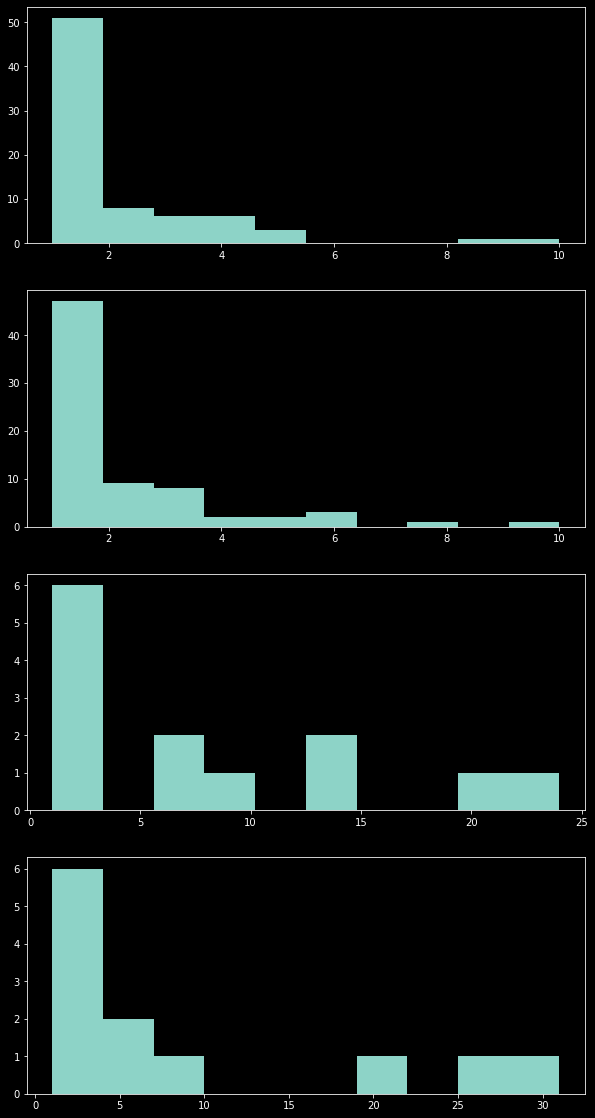

In [544]:
# # 결측값 보간하기
# fig, ax =plt.subplots(len(nan_cols),1,figsize=(10,20))
# for i in range(len(nan_cols)):
#     ax[i].hist(X_test[nan_cols[i]].value_counts().values)

In [550]:
# 뭐든지 알고 하자 모르면 무의식적으로 대충하게 된다
# fe_ (feature를 의미하고) 그 이후 값은 원래 존재하는 feature를 가지고 새로운 의미 feature를 만든 것
# fe_rent_per_person은 한명당 rent 비용 feature 를 만든 것이므로 mean 으로 fillna
# fe_rent_per_room 룸 하나당 비용


    # print(X_test[col].value_counts())

['fe_rent_per_person',
 'fe_rent_per_room',
 'fe_mobile_density',
 'fe_tablet_adult_density']

['fe_rent_per_person',
 'fe_rent_per_room',
 'fe_mobile_density',
 'fe_tablet_adult_density']

In [593]:
# df.fillna(method='bfill')
#
# for col in X_test.drop(xgb_drop_cols,axis=1).columns.tolist():
#     print('col {} null sum : {}'.format(col,X_test[col].isnull().sum()))

col v2a1 null sum : 0
col hacdor null sum : 0
col rooms null sum : 0
col hacapo null sum : 0
col refrig null sum : 0
col v18q1 null sum : 0
col r4h1 null sum : 0
col r4h2 null sum : 0
col r4h3 null sum : 0
col r4m1 null sum : 0
col r4m2 null sum : 0
col r4m3 null sum : 0
col r4t1 null sum : 0
col r4t2 null sum : 0
col escolari null sum : 0
col cielorazo null sum : 0
col dis null sum : 0
col male null sum : 0
col hogar_nin null sum : 0
col hogar_adul null sum : 0
col hogar_mayor null sum : 0
col hogar_total null sum : 0
col dependency null sum : 0
col edjefe null sum : 0
col edjefa null sum : 0
col meaneduc null sum : 0
col bedrooms null sum : 0
col overcrowding null sum : 0
col computer null sum : 0
col television null sum : 0
col qmobilephone null sum : 0
col area1 null sum : 0
col area2 null sum : 0
col age null sum : 0
col SQBescolari null sum : 0
col SQBage null sum : 0
col SQBhogar_total null sum : 0
col SQBedjefe null sum : 0
col SQBhogar_nin null sum : 0
col SQBovercrowding null

In [608]:
# len(X_test.drop(xgb_drop_cols,axis=1).columns)

143

In [609]:
# len(X_test.drop(et_drop_cols,axis=1).columns)

122

In [634]:
# ignore_test = test.drop(xgb_drop_cols, axis=1, errors='ignore')
#

In [638]:
# y_subm_lgb['Target'] = vc.predict(ignore_test)+ 1

ValueError: could not convert string to float: 'no'

In [645]:
# object_cols = []
# for col in ignore_test.columns.tolist():
#     if ignore_test[col].dtypes == 'object':
#         object_cols.append(col)

In [646]:
# ignore_test[object_cols]
# 처음 부터 다시 해야하나 전처리 안된게 왜 있찌 따라하는 것도 잘 못한다
# 긴 흐름을 잘 가져가는 연습필요 , 전처리 로직만 돌려야하나 , 어떤 피쳐를 활용하는지도 , 모델을 다시 트레이닝 할 수는없다

,dependency,edjefe,edjefa
0,.5,no,17
1,.5,no,17
2,.5,no,17
3,no,16,no
4,8,no,11
...,...,...,...
23851,.5,5,no
23852,yes,6,no
23853,yes,6,no
23854,yes,6,no


In [ ]:

# ignore_test.drop(['Id'] ,axis=1, inplace=True)

In [ ]:
# X_test[nan_cols] = X_test[nan_cols].fillna(0,inplace=True)

In [605]:
# 하나씩 해야되네 하나씩 하지 않으면 바뀌지가 않는다 fillna, 다른 방법 찾거나 해야한다
# 계속 한번에 바꿔서 replace할 때는 바뀌는데 여러개가 한번에 입력이 안되는건지 인서트해도 안되서 헤맸다
# 이런 짜증나는 오류가 있다 분명 될것처럼 해놓고 눈속임
# for col in nan_cols:
#     X_test[col]= X_test[col].fillna(0)

In [606]:
# X_test[nan_cols]

,fe_rent_per_person,fe_rent_per_room,fe_mobile_density,fe_tablet_adult_density
30,0,0,0,0
58,0,0,0,0
68,0,0,0,0
92,0,0,0,0
102,0,0,0,0
...,...,...,...,...
9492,0,0,0,0
9505,0,0,0,0
9517,0,0,0,0
9519,0,0,0,0


In [ ]:
# X_test[nan_cols].fillna(0,inplace=True)
#

In [ ]:
# X_test[nan_cols].fillna(X_test[nan_cols])

In [590]:
# #None 은 python singleton 객체 개념이다
# #
# X_test[X_test[nan_cols].isnull()][nan_cols]

,fe_rent_per_person,fe_rent_per_room,fe_mobile_density,fe_tablet_adult_density
30,NaN,NaN,NaN,NaN
58,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN
...,...,...,...,...
9492,NaN,NaN,NaN,NaN
9505,NaN,NaN,NaN,NaN
9517,NaN,NaN,NaN,NaN
9519,NaN,NaN,NaN,NaN


In [ ]:
# et_drop_cols
#

In [ ]:
# global_combo_score_soft = f1_score(y_test, combo_preds, average="macro")
# global_combo_score_soft

In [ ]:
from keras.models import Sequential

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [474]:
# y_ttt.shape

(2973, 11)

In [ ]:
# for col in X_train.drop(et_drop_cols,axis=1).columns.tolist():
#     print('col {} null sum : {}'.format(col,X_train[col].isnull().sum()))

In [434]:
# et_drop_cols = [col for col in et_drop_cols if len(col)>1]

In [435]:
# et_drop_cols

['agg18_age_MAX',
 'agg18_age_MEAN',
 'agg18_age_MIN',
 'agg18_dis_MEAN',
 'agg18_escolari_MAX',
 'agg18_escolari_MEAN',
 'agg18_escolari_MIN',
 'agg18_estadocivil1_COUNT',
 'agg18_estadocivil1_MEAN',
 'agg18_estadocivil2_COUNT',
 'agg18_estadocivil2_MEAN',
 'agg18_estadocivil3_COUNT',
 'agg18_estadocivil3_MEAN',
 'agg18_estadocivil4_COUNT',
 'agg18_estadocivil4_MEAN',
 'agg18_estadocivil5_COUNT',
 'agg18_estadocivil5_MEAN',
 'agg18_estadocivil6_COUNT',
 'agg18_estadocivil6_MEAN',
 'agg18_estadocivil7_COUNT',
 'agg18_estadocivil7_MEAN',
 'agg18_parentesco10_COUNT',
 'agg18_parentesco10_MEAN',
 'agg18_parentesco11_COUNT',
 'agg18_parentesco11_MEAN',
 'agg18_parentesco12_COUNT',
 'agg18_parentesco12_MEAN',
 'agg18_parentesco1_COUNT',
 'agg18_parentesco1_MEAN',
 'agg18_parentesco2_COUNT',
 'agg18_parentesco2_MEAN',
 'agg18_parentesco3_COUNT',
 'agg18_parentesco3_MEAN',
 'agg18_parentesco4_COUNT',
 'agg18_parentesco4_MEAN',
 'agg18_parentesco5_COUNT',
 'agg18_parentesco5_MEAN',
 'agg18_par

In [437]:
# et_drop_cols.extend(['fe_mobile_density'])

In [340]:
# X_train_x = X_train.astype('float32')

In [ ]:
#for i in range(10):
#    print(sqrt(i ** 2))
# 위의 코드를 cpu 를 적절히 할당해서 print lst할때 그 자체로 내부에서 병렬 처리해서 return 한다는 뜻이다. 결과가 같은게
# 중요한게 아니라
# 위 코드를 병렬처리할 수 있습니다.
#
# import time
# from math import sqrt

# 우선 병렬 처리를 위해서 Parallel를 가져옵니다.
#
# lst = Parallel(n_jobs=2,prefer="threads")(delayed(sqrt)(i ** 2) for i in range(10))
# print(lst)
# Parallel delayed()
# delayed(func)(parameters) func에 parameters 를 주고 n_jobs만큼의 cpu에 할당해서 처리하여 준다
#
# Parallel(n_jobs=self.n_jobs)(delayed(_parallel_fit_estimator)(clone(clf) , X, transformed_y))

In [ ]:
# # 의도치 않게 실행되지 않도록 raise, 넘어가는 것은 except
# clf_final = vc.estimators_[0]

In [ ]:
# ests = []
#
# for i in range():
#     est = RandomForestClassifier(random_state=42+i , n_estimators=50,

In [ ]:
# clf_final = vc.estimators[0]

In [ ]:
"""
2번째 필사적 필사는 조금 간격을 두고 진행해 보자


The LightGBM models have been repalce with XGBoost and the code has been updated accordingly
i am also fitting VotingClassifiers of RandomForests and ensembling the results of the XGBs with the RFs
Some additional features have been added
some features which were previously dropped have been retaied
Some of the code has beedn reorganized
#
Rathar than splitting the data once and using the validation data for the LGBM early stopping , i split the data during the training so the enitre training set
can be trained on . i found that this works better than a k-fold split in this case
병렬 프로그래밍을 활용해서 트레이닝 중에 데이터 를 섞어서 모든 데이터가 트레이닝 되도록 했다

Some additional features were taken from : url


Notes from original Kernel


this kernel closely follows url, but instead of running hyperparameter optimisation it
uses optimal values from that kernel and thus runs fater
Several key points

"""
